
# HW17. Kobe Bryantshot selection - Linear Regression, Lasso, Ridge, PCA

ДАНИЛЬЧЕНКО ВАДИМ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [2]:
data = pd.read_csv('Kobe.csv')

In [3]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC

In [5]:
# посмотрим на полноту данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

пропуски есть только в целевой переменной 

на данном этапе посмотрим на данные, также определим набор с пропусками в тестовую выборку, остальные в тренировочную

In [6]:
train=data[data.shot_made_flag.isna()==False]
test=data[data.shot_made_flag.isna()==True]

# посмотрим на количество представленных периодов
len(data.game_date.unique())

1559

1,5 тысячи игр, невероятно) посмотрим за какой промежуток времени

In [7]:
from datetime import datetime
from dateutil import relativedelta as rd

start=datetime.strptime(min(data.game_date.unique()),'%Y-%m-%d')
finish=datetime.strptime(max(data.game_date.unique()),'%Y-%m-%d')
years=rd.relativedelta(finish, start)
# type(years)
print('карьера Коби Брайанта длилась {} полных лет: '.format(years.years), start,":", finish, ', т.е. в среднем {:.0f} \
игры в год'.format(len(data.game_date.unique())/years.years))

карьера Коби Брайанта длилась 19 полных лет:  1996-11-03 00:00:00 : 2016-04-13 00:00:00 , т.е. в среднем 82 игры в год


In [8]:
# посмотрим сколько из бросков увенчались успехом (используем данные из тренировочной выборки)
f'по данным тренировочной выборки точность бросков за всю карьеру {train[train.shot_made_flag==1].shot_made_flag.count()\
    /train.shot_made_flag.count()*100:.02f}%'

'по данным тренировочной выборки точность бросков за всю карьеру 44.62%'

посмотрим как менялась точность по годам от количества игр

In [9]:
data['year']=pd.DatetimeIndex(data.game_date).year
train=data[data.shot_made_flag.isna()==False]
train_acc_shots=train.groupby(['year']).agg({'shot_made_flag':'sum', 'action_type':'count'})
train_acc_shots['accuracy']=train_acc_shots.shot_made_flag/train_acc_shots.action_type
train_games_year=train.groupby('game_date').year.unique().reset_index()
train_games_year.year=train_games_year.year.astype(int)
train_games_year=train_games_year.year.value_counts().reset_index().rename(columns={'year':'games','index':'year'})
train_acc_shots=train_acc_shots.merge(train_games_year, on='year', how='left')
train_acc_shots

,year,shot_made_flag,action_type,accuracy,games
0,1996,26.0,69,0.376812,21
1,1997,269.0,625,0.430400,80
2,1998,216.0,499,0.432866,62
3,1999,453.0,983,0.460834,73
4,2000,809.0,1716,0.471445,105
5,2001,646.0,1397,0.462419,79
6,2002,822.0,1860,0.441935,104
7,2003,695.0,1608,0.432214,89
8,2004,646.0,1506,0.428951,86
9,2005,568.0,1267,0.448303,68


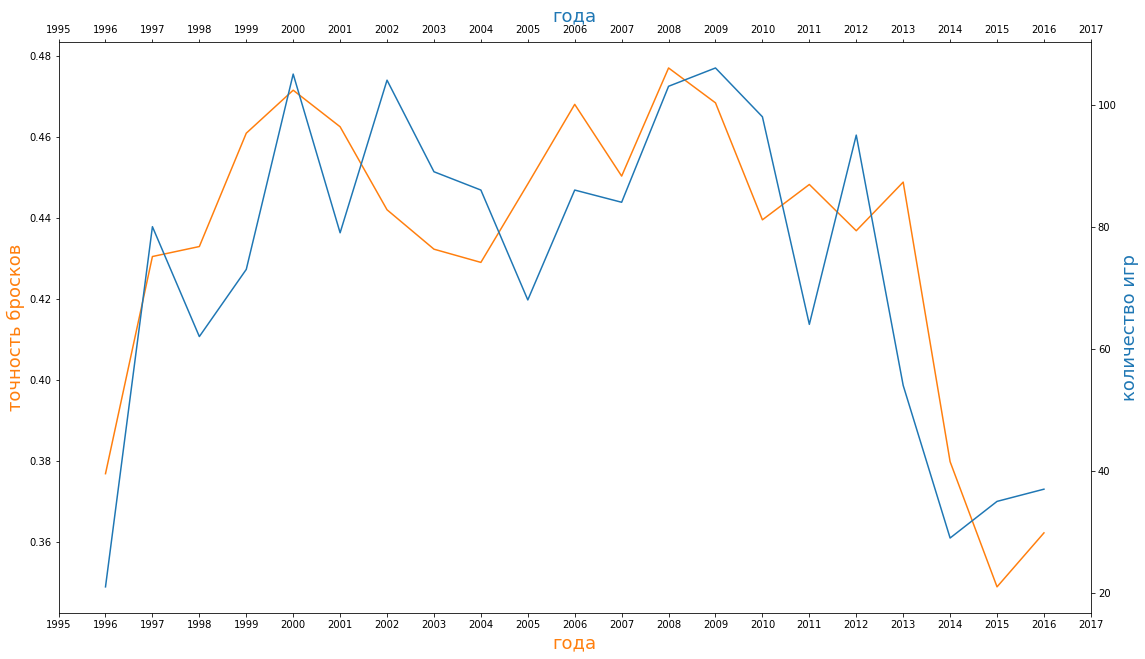

In [10]:
# визуализируем
import matplotlib.ticker as ticker

fig=plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.set_xlabel('года', color="C1", fontsize=18) 
ax.set_ylabel('точность бросков', color="C1", fontsize=18)       
ax.xaxis.set_label_position('bottom') 
ax.yaxis.set_label_position('left') 
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax.plot(train_acc_shots.year, train_acc_shots.accuracy, color="C1")

ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('года', color="C0", fontsize=18) 
ax2.set_ylabel('количество игр', color="C0", fontsize=18)       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax2.plot(train_acc_shots.year, train_acc_shots.games, color="C0")

видим, что точность бросков просела с 2002 по 2004, потом восстановилась, 
а с 2013 года точность и количество игр заметно уменьшилось
возможно это связано с участием в команде, проверим

In [11]:
train.team_name.value_counts()

Los Angeles Lakers    25697
Name: team_name, dtype: int64

видим, что все время играл за одну команду

проверим точность бросков от среднего расстояния до корзины

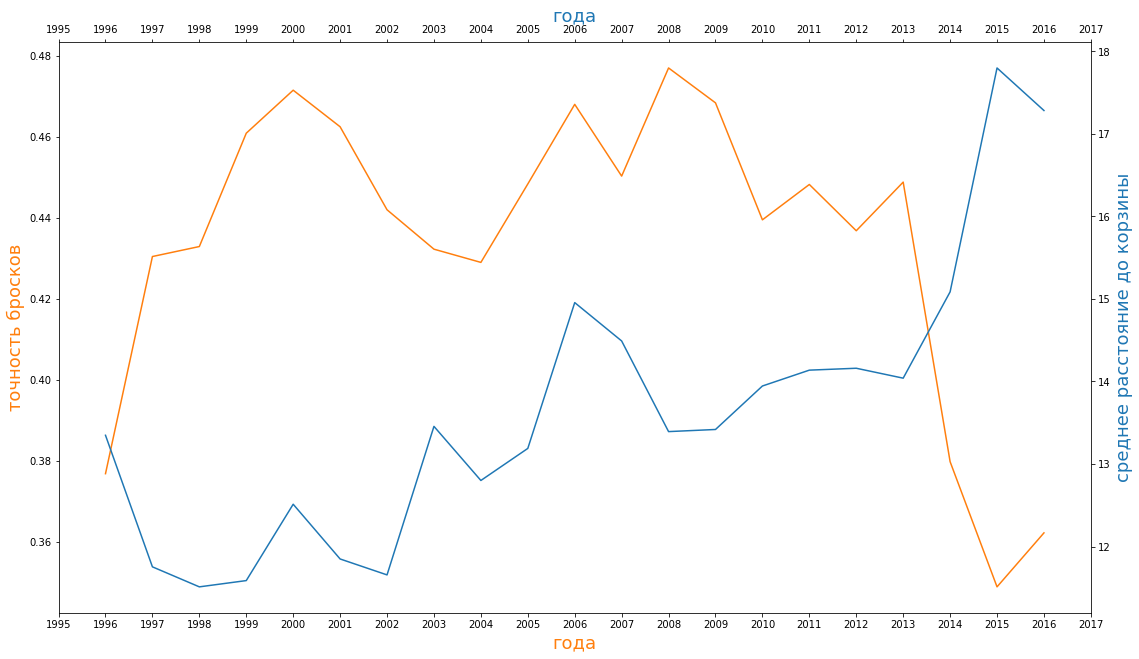

In [12]:
train_dist_avg=train.groupby(['year']).shot_distance.mean().reset_index().rename(columns={'shot_distance':'avg_distance'})
train_acc_shots=train_acc_shots.merge(train_dist_avg, on='year', how='left')
# train_acc_shots

fig=plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.set_xlabel('года', color="C1", fontsize=18) 
ax.set_ylabel('точность бросков', color="C1", fontsize=18)       
ax.xaxis.set_label_position('bottom') 
ax.yaxis.set_label_position('left') 
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax.plot(train_acc_shots.year, train_acc_shots.accuracy, color="C1")

ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('года', color="C0", fontsize=18) 
ax2.set_ylabel('среднее расстояние до корзины', color="C0", fontsize=18)       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax2.plot(train_acc_shots.year, train_acc_shots.avg_distance, color="C0")

заметна зависимость - чем меньше расстояние до корзины, тем точнее броски. Также интересно, что чем старше он становился, тем на меньшее расстояние он мог подходить к корзине, либо его позиция на поле изменилась, надо проверить

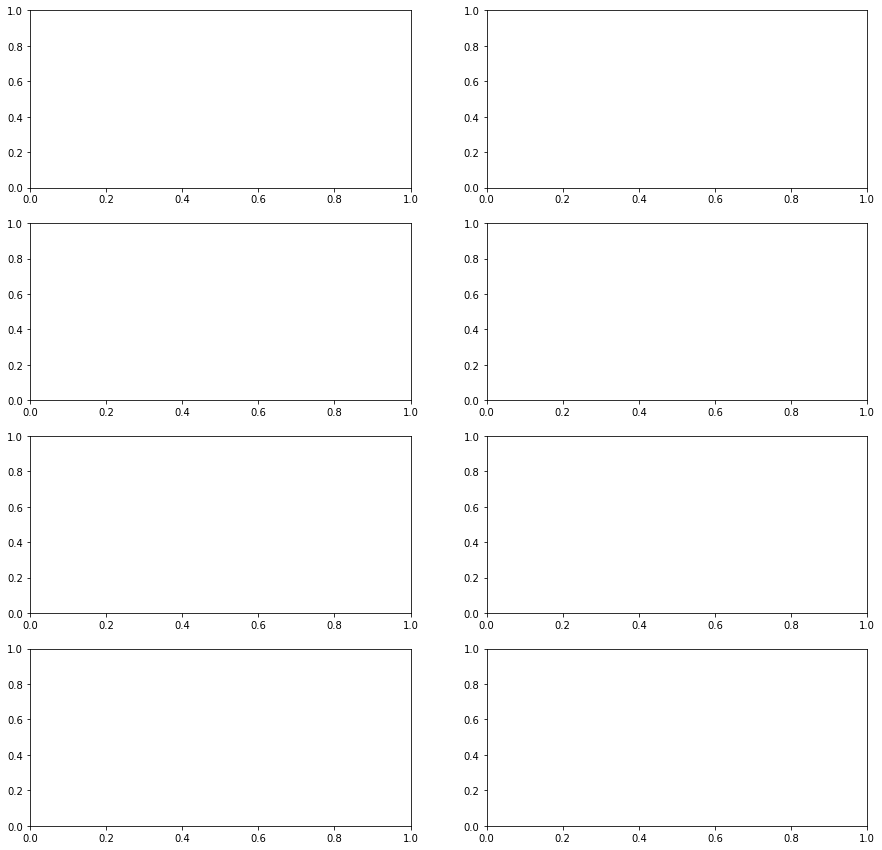

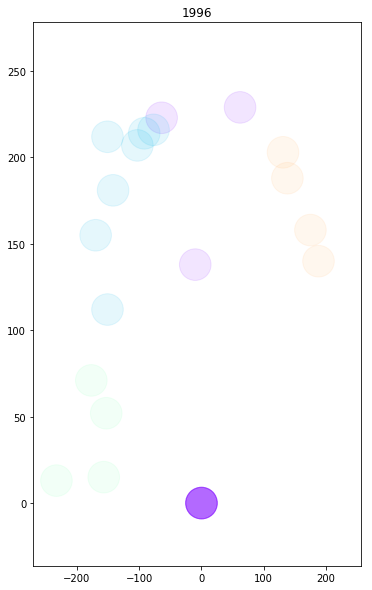

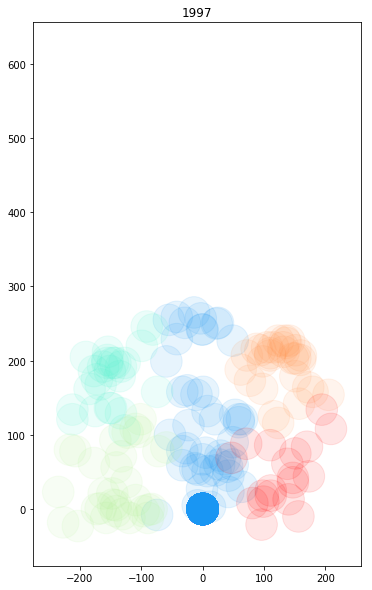

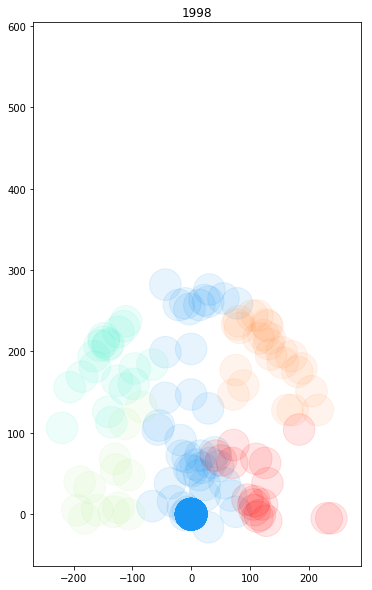

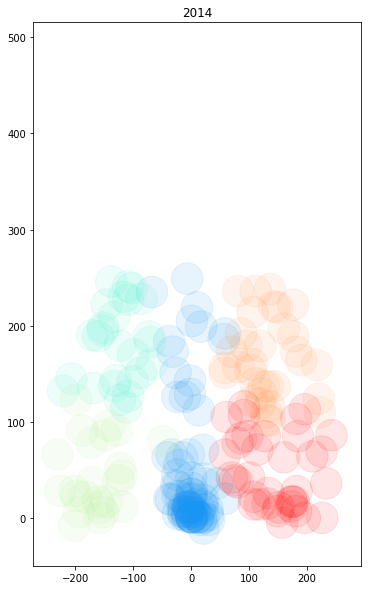

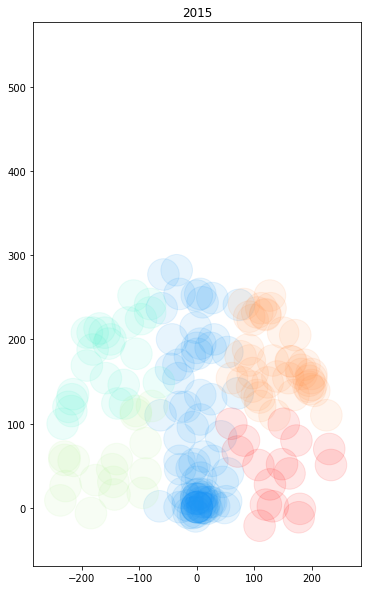

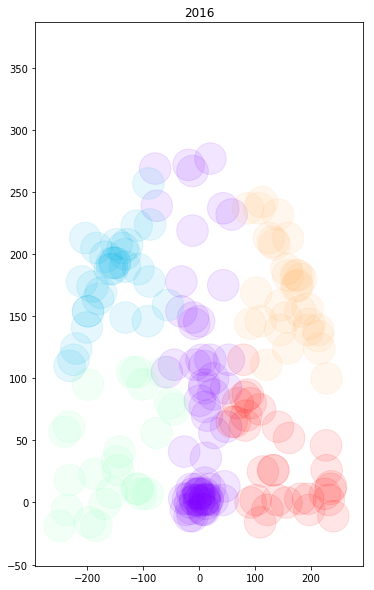

In [13]:
import matplotlib.cm as cm
f, axarr = plt.subplots(4, 2, figsize=(15, 15))

def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = train.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, s=g[1].shot_made_flag*1000, color=c, alpha=alpha)

# выведем shot_zone_area за первых три и последних три года
first_last_3_year=sorted(train.year.unique(), reverse = False)[:3]+sorted(train.year.unique(), reverse = False)[-3:]
for i in first_last_3_year:
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.title(i)
    
    scatter_plot_by_category(train[train.year==i]['shot_zone_area'])
#     plt.legend(train[train.year==i].shot_zone_area.unique())
plt.show()

на первый взгляд больше точных бросков с позиции "Center(C)"

посмотрим на точность бросков по зонам на тепловой карте

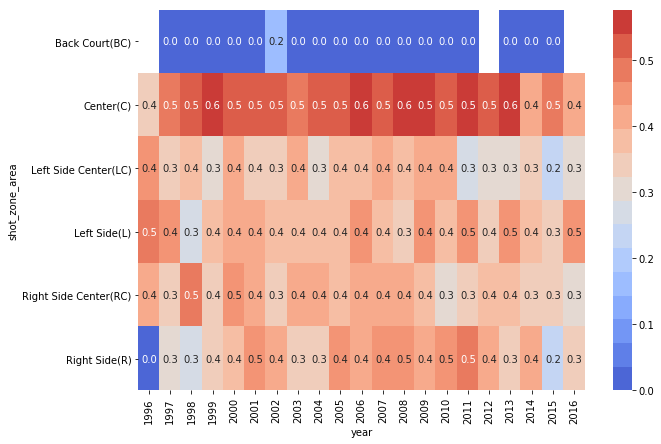

In [14]:
import seaborn as sns
train_pvt=train.groupby(['year','shot_zone_area']).agg({'shot_made_flag':'sum','game_date':'count'}).reset_index().\
    rename(columns={'shot_made_flag':'summ','game_date':'cnt'})
train_pvt['accuracy']=train_pvt.summ/train_pvt.cnt
train_pvt=train_pvt.pivot_table(
            columns='year',
            index='shot_zone_area',
            values='accuracy',
            aggfunc=sum)
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(train_pvt, annot=True, fmt='.1f', ax=ax, cmap=sns.color_palette('coolwarm', 16))

теперь видно, что лучшая точность его броска из зоны "Center". только броски с "Left Side" стали точнее, остальное стало хуже с возрастом. 

интересно из каких зон он больше всего совершал бросков в общем, так сказать "рабочая зона"

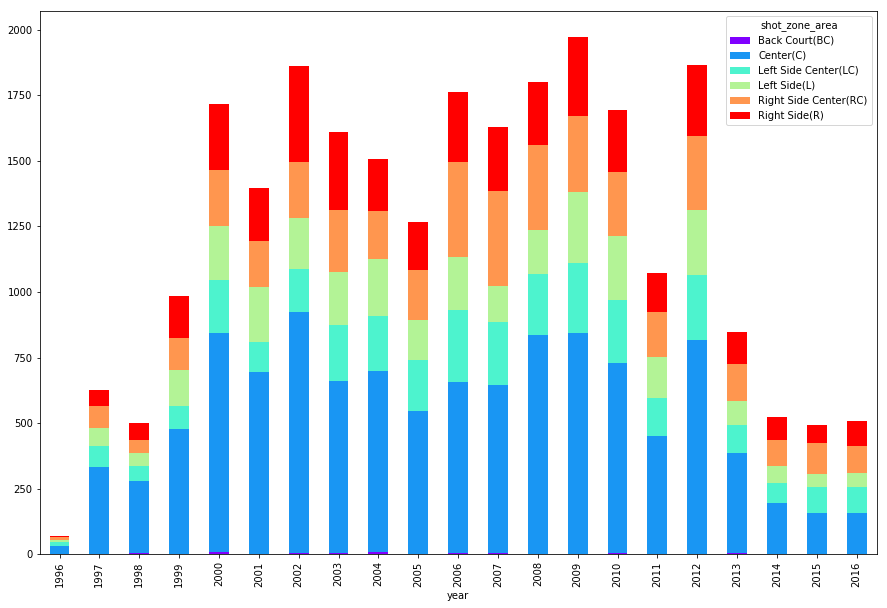

In [15]:
train_pvt=train.groupby(['year','shot_zone_area']).agg({'shot_made_flag':'sum','game_date':'count'}).reset_index().\
    rename(columns={'shot_made_flag':'summ','game_date':'cnt'})
train_pvt=train_pvt.pivot_table(
            columns='shot_zone_area',
            index='year',
            values='cnt',
            aggfunc=sum)
colors = cm.rainbow(np.linspace(0, 1, len(train_pvt.columns)))
train_pvt.plot.bar(stacked=True, color=colors, figsize=(15,10))

действительно центр самая частая позиция для броска и самая удачная по точности

проверим есть ли разница в точности от периода игры

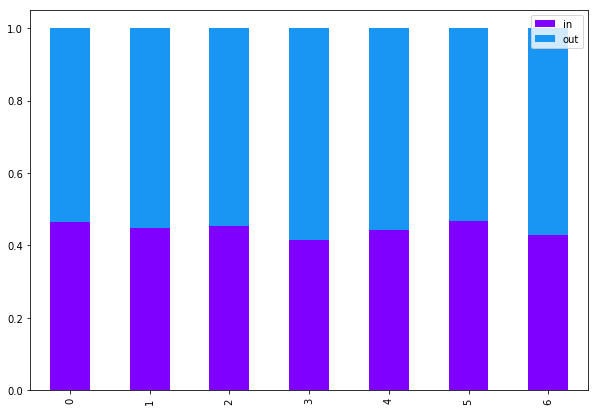

In [16]:
train_period_acc=train.groupby(['period']).agg({'shot_made_flag':'sum','game_date':'count'}).reset_index().\
    rename(columns={'shot_made_flag':'summ','game_date':'cnt'})
train_period_acc['in']=train_period_acc.summ/train_period_acc.cnt
train_period_acc['out']=1-train_period_acc['in']#train_period_acc.summ/train_period_acc.cnt
train_period_acc.drop(columns={'cnt','summ'}, inplace=True)
colors = cm.rainbow(np.linspace(0, 1, len(train_pvt.columns)))
train_period_acc[['in','out']].plot.bar(stacked=True, color=colors, figsize=(10,7))

немного меньше в 4м и 7м периоде (не понятно, это похоже не таймы), но в целом точность в диапазоне 41-47%
посмотрим как меняется точность броска от количества оставшихся минут

<BarContainer object of 12 artists>

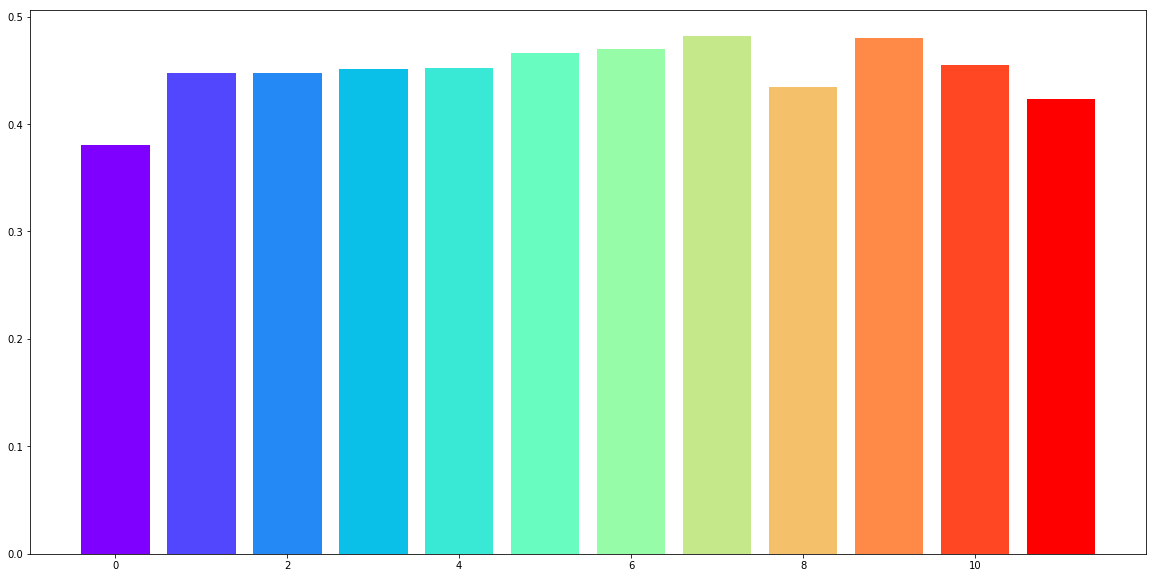

In [17]:
train_minutes_acc=train.groupby(['minutes_remaining']).agg({'shot_made_flag':'sum','game_date':'count'}).reset_index().\
    rename(columns={'shot_made_flag':'summ','game_date':'cnt'})
train_minutes_acc['accuracy']=train_minutes_acc.summ/train_minutes_acc.cnt
colors=cm.rainbow(np.linspace(0, 1, len(train_minutes_acc.minutes_remaining)))
plt.figure(figsize=(20,10))
plt.bar(train_minutes_acc.minutes_remaining, train_minutes_acc.accuracy, color=colors)

самая меньшая точность при бросках в последнюю минуту до конца тайма, точнее всего броски на 7й и 9й минуте

посмотрим на точность броска от типа (combined_shot_type)

<BarContainer object of 6 artists>

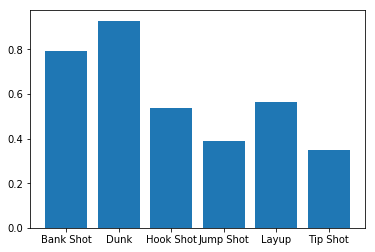

In [18]:
train_type_shot_acc=(train[train.shot_made_flag==1].combined_shot_type.value_counts()/train.combined_shot_type.value_counts())\
    .reset_index().rename(columns={'combined_shot_type':'accuracy', 'index':'type_shot'})
plt.bar(train_type_shot_acc.type_shot, train_type_shot_acc.accuracy)

Топ 1 точности - "Dunk", второй "Bank Shot"

возможно количество бросков этих типов незначительно мало из-за своей специфики, отсюда и такая точность, надо проверить

<BarContainer object of 6 artists>

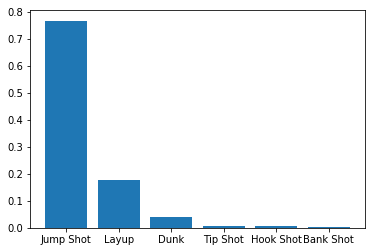

In [19]:
train_shot_cnt=train.combined_shot_type.value_counts().reset_index()\
    .rename(columns={'combined_shot_type':'cnt', 'index':'type_shot'})
train_shot_cnt['share']=train_shot_cnt['cnt']/train_shot_cnt.cnt.sum()
plt.bar(train_shot_cnt.type_shot, train_shot_cnt.share)

почти 75% из всех составляют броски типа "Jump Shot", у них же один из самых низких показателей точности, а самые точные
броски "Bank Shot" и "Dunk" составляют менее 5% всех бросков, исключение "Tip Shot" - и редко и мимо :)

думаю можно сгруппировать три последних типа броска в "Other"

In [20]:
other_shots = data['combined_shot_type'].value_counts().sort_values().index.values[:3]
data['comb_shot_grouped']=data['combined_shot_type']
data.loc[data['comb_shot_grouped'].isin(other_shots), 'comb_shot_grouped'] = 'Other'
data.comb_shot_grouped.value_counts()

Jump Shot    23485
Layup         5448
Dunk          1286
Other          478
Name: comb_shot_grouped, dtype: int64

посмотрим оппонента

<BarContainer object of 33 artists>

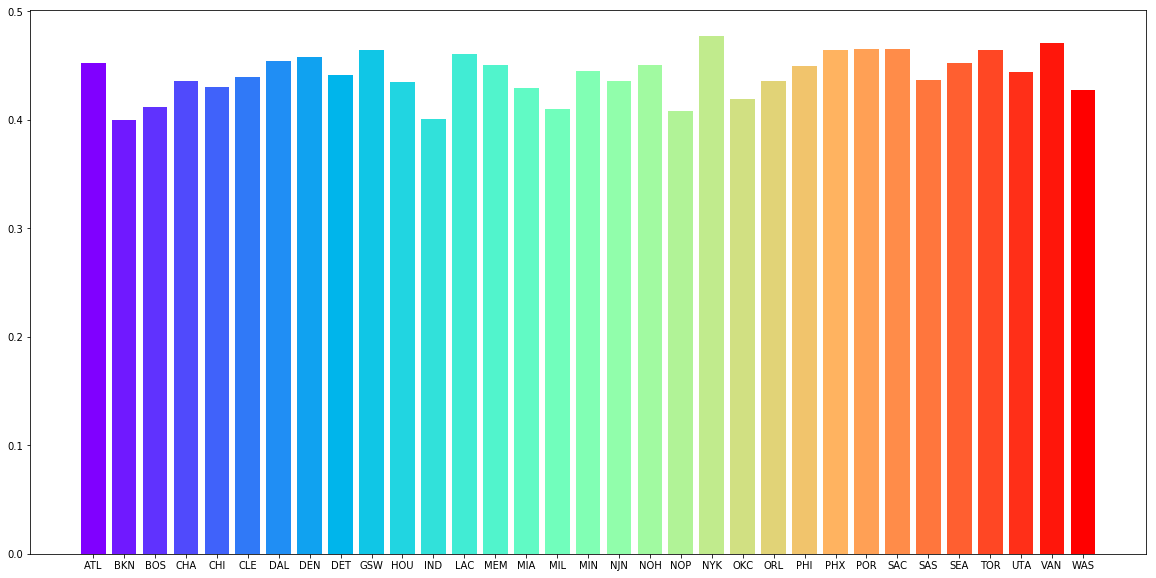

In [21]:
# train.opponent.unique()
train_opponent_acc=train.groupby('opponent').agg({'shot_made_flag':'sum','game_date':'count'}).reset_index().\
    rename(columns={'shot_made_flag':'summ','game_date':'cnt'})
train_opponent_acc['accuracy']=train_opponent_acc.summ/train_opponent_acc.cnt

colors=cm.rainbow(np.linspace(0, 1, len(train_opponent_acc.opponent)))
plt.figure(figsize=(20,10))
plt.bar(train_opponent_acc.opponent, train_opponent_acc.accuracy, color=colors)

думаю по точности росков можно судить о качестве командной игры оппонента - чем команда лучше играет, тем на большеее
расстояние для броска мог пробраться Коби, а как мы видели ранее точность достаточно хорошая при расстоянии до 14(возможно 
метры)

проверим на 2 лучших и 2 худших результатах

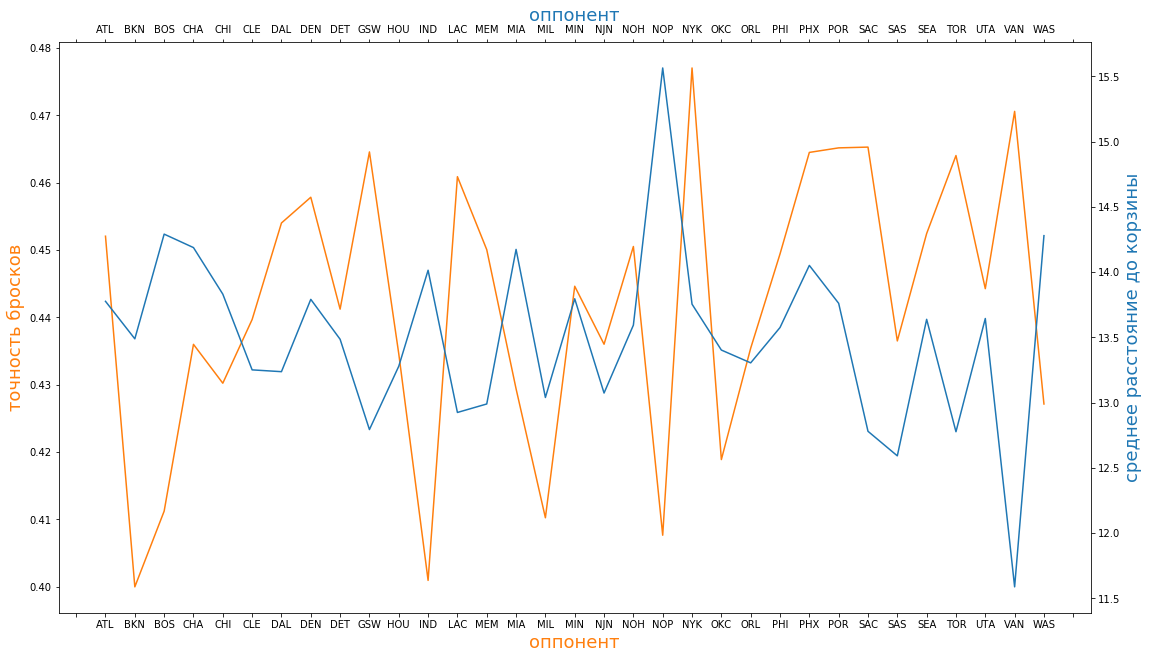

In [22]:
train_opponent_dist=train.groupby('opponent').agg({'shot_distance':'mean'}).reset_index().\
        rename(columns={'shot_distance':'avg_dist'})
train_opponent_acc=train_opponent_acc.merge(train_opponent_dist, on='opponent', how='left')

fig=plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.set_xlabel('оппонент', color="C1", fontsize=18) 
ax.set_ylabel('точность бросков', color="C1", fontsize=18)       
ax.xaxis.set_label_position('bottom') 
ax.yaxis.set_label_position('left') 
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax.plot(train_opponent_acc.opponent, train_opponent_acc.accuracy, color="C1")

ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('оппонент', color="C0", fontsize=18) 
ax2.set_ylabel('среднее расстояние до корзины', color="C0", fontsize=18)       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax2.plot(train_opponent_acc.opponent, train_opponent_acc.avg_dist, color="C0")

действительно от команды зависит дистанция для броска, 
например, на графике хорошо видно, что команда NOP (вероятно Нью-Орлеан Пеликанс) в среднем держала Коби на расстоянии 15 метров
и его точность упала ниже 41%, а вот NYK (Нью-Йорк Никс) позволили проходить в среднем на 1,5 метра дальше NOP и броски стали 
заметно точнее

проверим линейную связь

In [23]:
train_opponent_acc[['accuracy','avg_dist']].corr()

,accuracy,avg_dist
accuracy,1.000000,-0.443081
avg_dist,-0.443081,1.000000


коэффициент корреляции -0,44 подтверждает гипотезу об обратной линейной зависимости между расстоянием до корзины и точностью

проверим есть ли зависимость в точности от дня недели

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<BarContainer object of 7 artists>

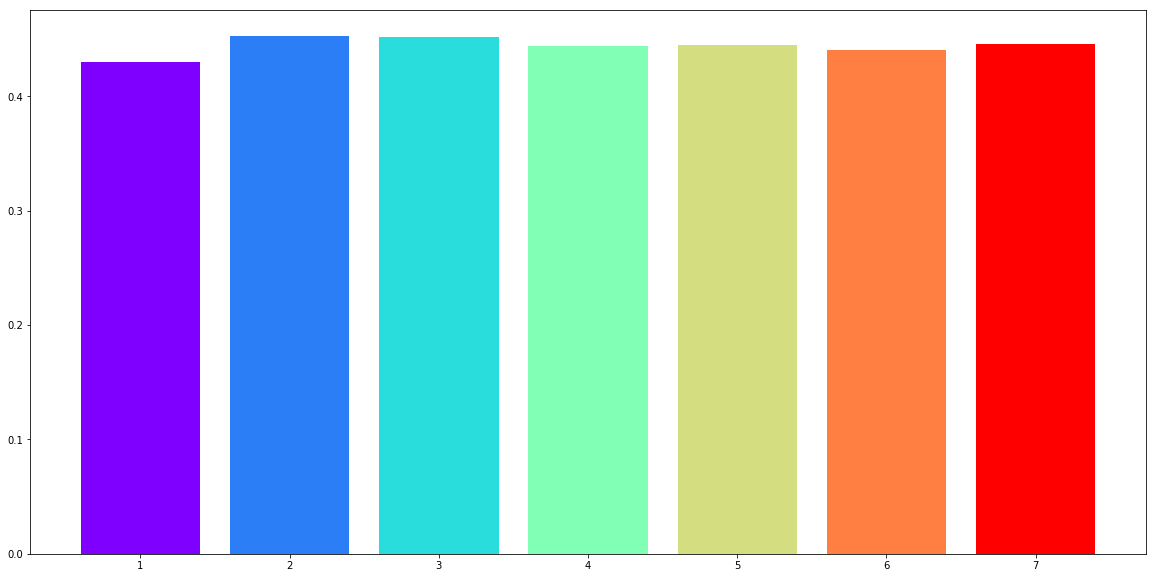

In [24]:
data['weekday']=pd.DatetimeIndex(data.game_date).weekday+1
train=data[data.shot_made_flag.isna()==False]
train['weekday']=pd.DatetimeIndex(train.game_date).weekday+1
train_weekday_acc=train.groupby(['weekday']).agg({'shot_made_flag':'sum','game_date':'count'}).reset_index().\
    rename(columns={'shot_made_flag':'summ','game_date':'cnt'})
train_weekday_acc['accuracy']=train_weekday_acc.summ/train_weekday_acc.cnt
# train_weekday_acc['accuracy'].plot.bar()
colors=cm.rainbow(np.linspace(0, 1, len(train_weekday_acc.weekday)))
plt.figure(figsize=(20,10))
plt.bar(train_weekday_acc.weekday, train_weekday_acc.accuracy, color=colors)

заметно, что в понедельник точность хуже, во вторник и среду лучше всего. 
возможно дело в том, что в понедельник проходят менее важные игры или же наоборот самые тяжелые

посмотрим есть ли зависимость от участия в плей-офф в целом и по дням недели

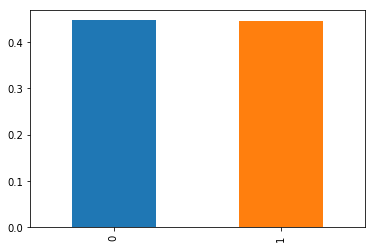

In [25]:
train_playoff_acc=train.groupby('playoffs').agg({'shot_made_flag':'sum','game_date':'count'}).reset_index().\
    rename(columns={'shot_made_flag':'summ','game_date':'cnt'})
train_playoff_acc['accuracy']=train_playoff_acc.summ/train_playoff_acc.cnt
train_playoff_acc['accuracy'].plot.bar()

в целом точность не отличается от того, плей-офф ли это или же нет

разложим по дням недели

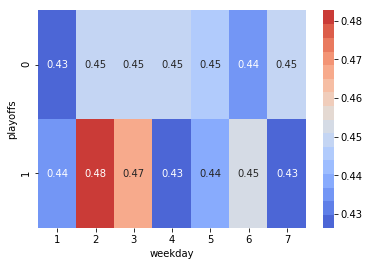

In [26]:
train_playoff_acc=train.groupby(['playoffs','weekday']).agg({'shot_made_flag':'sum','game_date':'count'}).reset_index().\
    rename(columns={'shot_made_flag':'summ','game_date':'cnt'})
train_playoff_acc['accuracy']=train_playoff_acc.summ/train_playoff_acc.cnt
train_playoff_acc_pvt=train_playoff_acc.pivot_table(
                        columns='weekday',
                        index='playoffs',
                        values='accuracy',
                        aggfunc='sum')
sns.heatmap(train_playoff_acc_pvt, annot=True, cmap=sns.color_palette('coolwarm', 16))

хоть в среднем-то отличий между между точностью в плей-оффе и классикой нет, но по дням недели есть: максимальная точность достигается в плей-оффе во вторник и среду (при этом такой точности нет в классике), но худшие же 
результаты в пн(0 флаг playoffs) и в четверг+воскресение (флаг 1 в playoffs), используем далее в модели

проверим зависит ли точность от дней между играми

In [27]:
# для начала отсортируем уникальные значения по возрастанию, затем вычтем из каждой даты предыдущую и запишем дни в словарь
spis={}
dates=data.game_date.sort_values().unique()
for i in range(len(dates)):
    spis.setdefault(dates[i],[])
    spis[dates[i]]=(datetime.strptime(dates[i],'%Y-%m-%d')-datetime.strptime(dates[i-1],'%Y-%m-%d')).days
spis['1996-11-03']=0

# эта функция нам будет возвращать дни для нового поля исходного датафрейма (merge не сработает из-за повторяющихся дат и
# несоответствия размеру вставки)
def days_from_prev_game(date):
    return spis[date]

# создадим новое поле в исходном датафрейме со списком дней с прошлой игры
data['days_from_prev_game']=data.game_date.apply(days_from_prev_game)
train=data[data.shot_made_flag.isna()==False]

# сгруппируем по дням с прошлой игры и посчитаем точность бросков
train_days_from_prev_game=train.groupby('days_from_prev_game').agg({'shot_made_flag':'sum','game_date':'count'}).reset_index().\
    rename(columns={'shot_made_flag':'summ','game_date':'cnt'})
train_days_from_prev_game['accuracy']=train_days_from_prev_game.summ/train_days_from_prev_game.cnt
# посмотрим  на корреляцию
train_days_from_prev_game[['accuracy','days_from_prev_game']].corr()

,accuracy,days_from_prev_game
accuracy,1.000000,-0.051523
days_from_prev_game,-0.051523,1.000000


можно сказать, что от количества дней перед игрой точность линейно не зависит, посмотрим на графике

<BarContainer object of 34 artists>

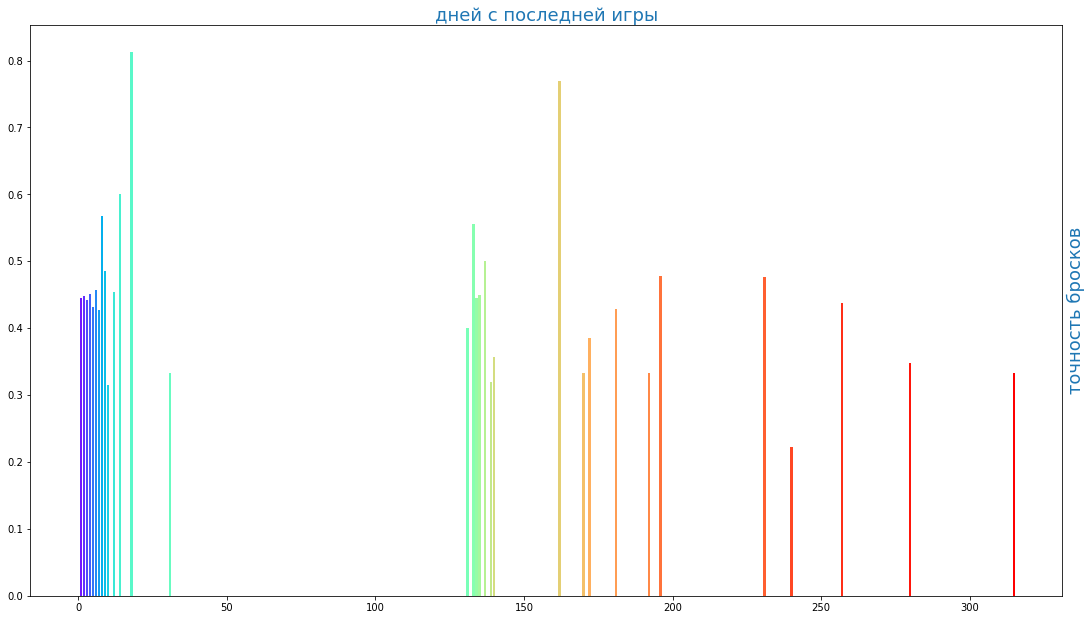

<Figure size 1440x720 with 0 Axes>

In [28]:
fig=plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)
colors=cm.rainbow(np.linspace(0, 1, len(train_days_from_prev_game.days_from_prev_game)))
ax=fig.add_subplot(111, label="1")
plt.figure(figsize=(20,10))
ax.set_xlabel('дней с последней игры', color="C0", fontsize=18) 
ax.set_ylabel('точность бросков', color="C0", fontsize=18)       
ax.xaxis.set_label_position('top') 
ax.yaxis.set_label_position('right') 
ax.bar(train_days_from_prev_game.days_from_prev_game, train_days_from_prev_game.accuracy, color=colors)

возможно есть какие-то дополнительные влияющие на это факторы, о которых мы не знаем

подозреваю, что количество игр с разницей более 50 дней с прошлой игры незначительно, 
надо это проверить и пересчитать зависимость

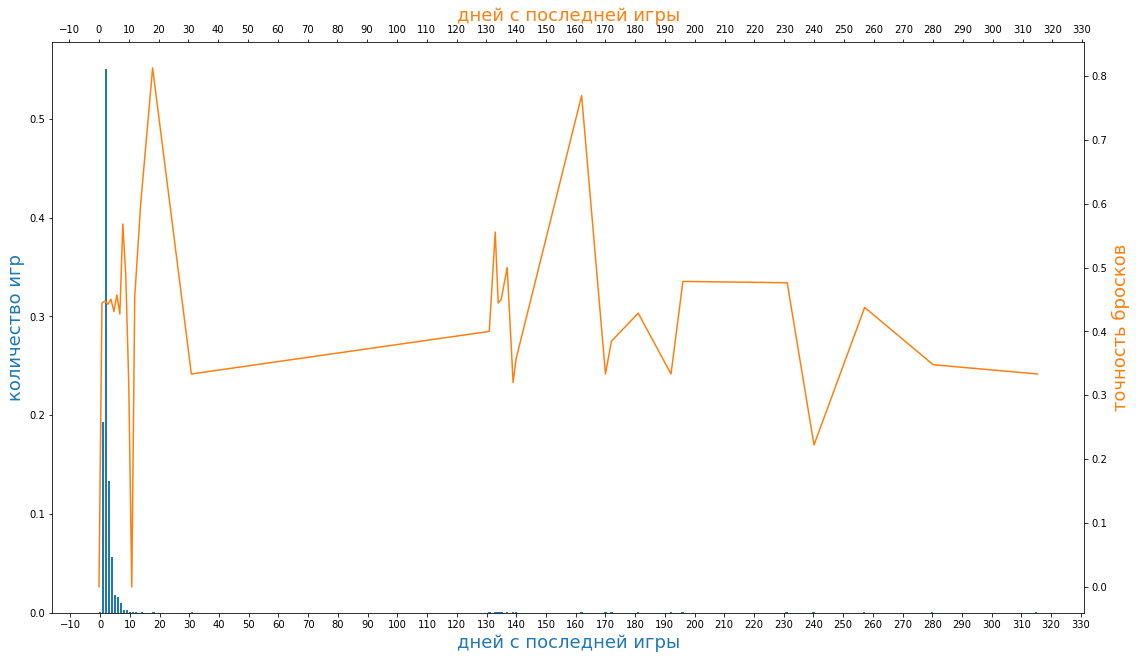

In [29]:
# сгруппируем по дням с прошлой игры, а также выведем количество игр с такой дельтой, затем посчитаем точность бросков
train_days_from_prev_game=train.groupby(['days_from_prev_game', 'game_date']).agg({'shot_made_flag':'sum','opponent':'count'})\
    .reset_index().rename(columns={'shot_made_flag':'summ','opponent':'cnt'})
train_days_from_prev_game=train_days_from_prev_game.groupby('days_from_prev_game')\
    .agg({'game_date':'count', 'summ':'sum', 'cnt':'sum'}).reset_index()
train_days_from_prev_game['accuracy']=train_days_from_prev_game.summ/train_days_from_prev_game.cnt
train_days_from_prev_game.rename(columns={'game_date':'games_cnt'}, inplace=True)
train_days_from_prev_game['games_percent_total']=train_days_from_prev_game.games_cnt/train_days_from_prev_game.games_cnt.sum()
# train_days_from_prev_game

# отобразим распределение по доле игр в общем количестве, также точности от дней с прошлой игры
fig=plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.set_xlabel('дней с последней игры', color="C0", fontsize=18) 
ax.set_ylabel('количество игр', color="C0", fontsize=18)       
ax.xaxis.set_label_position('bottom') 
ax.yaxis.set_label_position('left') 
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

ax.bar(train_days_from_prev_game.days_from_prev_game, train_days_from_prev_game.games_percent_total, color="C0")

ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('дней с последней игры', color="C1", fontsize=18) 
ax2.set_ylabel('точность бросков', color="C1", fontsize=18)       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))

ax2.plot(train_days_from_prev_game.days_from_prev_game, train_days_from_prev_game.accuracy, color="C1")

In [30]:
# действительно, 98% игр прошли с разницей менее 10 дней, посчитаем медиану
train_days_from_prev_game2=train.groupby(['days_from_prev_game', 'game_date']).agg({'shot_made_flag':'sum','opponent':'count'})\
    .reset_index().rename(columns={'shot_made_flag':'summ','opponent':'cnt'})
print('медиана дней между играми: {}'.format(train_days_from_prev_game2.days_from_prev_game.median()))

медиана дней между играми: 2.0


посмотрим какая точность на итервале между играми менее 10 дней

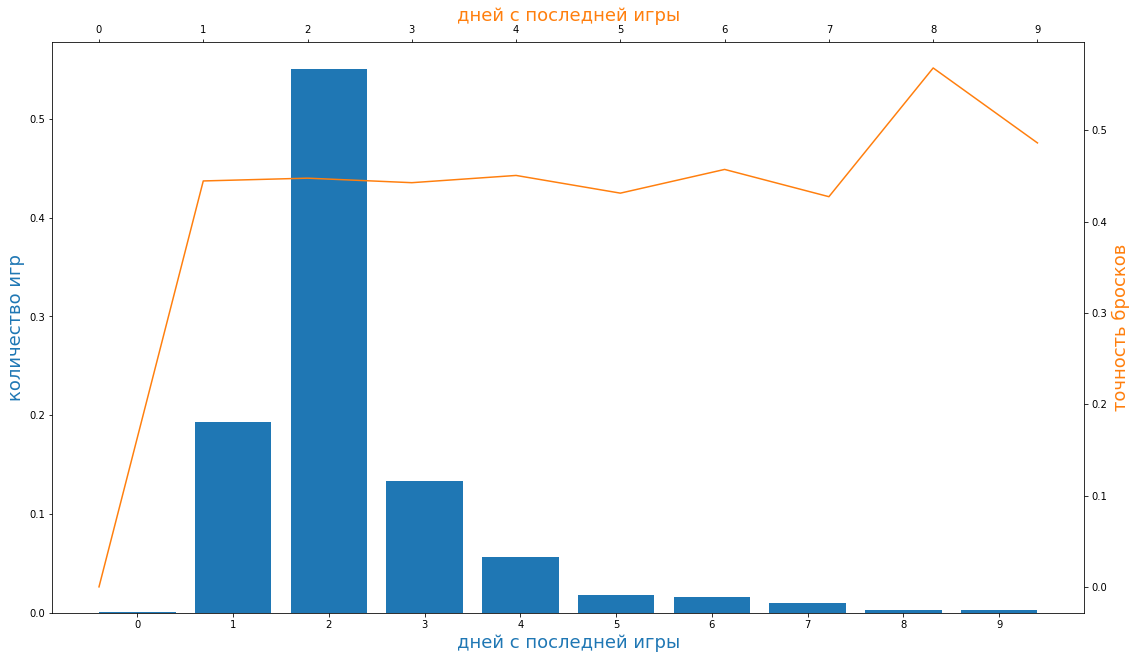

In [31]:
fig=plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.set_xlabel('дней с последней игры', color="C0", fontsize=18) 
ax.set_ylabel('количество игр', color="C0", fontsize=18)       
ax.xaxis.set_label_position('bottom') 
ax.yaxis.set_label_position('left') 
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax.bar(train_days_from_prev_game[train_days_from_prev_game['days_from_prev_game']<10].days_from_prev_game, \
       train_days_from_prev_game[train_days_from_prev_game['days_from_prev_game']<10].games_percent_total, color="C0")

ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('дней с последней игры', color="C1", fontsize=18) 
ax2.set_ylabel('точность бросков', color="C1", fontsize=18)       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax2.plot(train_days_from_prev_game[train_days_from_prev_game['days_from_prev_game']<10].days_from_prev_game, \
         train_days_from_prev_game[train_days_from_prev_game['days_from_prev_game']<10].accuracy, color="C1")

В общем действительно не зависит, есть немного игр с разницей 8-9 дней, в которых точность была выше 50%, но основная масса
сосредоточена около 43-46%, 
по идее играми с разницей более 4х дней (7% наблюдений) в модели можно пренебречь, только лишний шум, дальше будет видно

посмотрим на распределение количества очков за бросок

<BarContainer object of 2 artists>

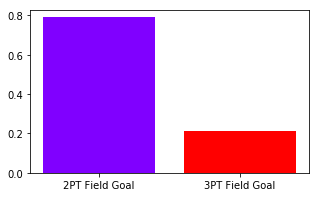

In [32]:
train_shots=train.shot_type.value_counts().reset_index().rename(columns={'shot_type':'cnt', 'index':'shot_type'})
colors=cm.rainbow(np.linspace(0, 1, len(train_shots.shot_type)))
plt.figure(figsize=(5,3))
plt.bar(train_shots.shot_type, train_shots.cnt/train_shots.cnt.sum(), color=colors)

почти 80% бросков составляют стандартные двухочковые броски

посмотрим на зависисмость между широтой, долготой, loc_x, loc_y

D:\Program Files\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
D:\Program Files\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


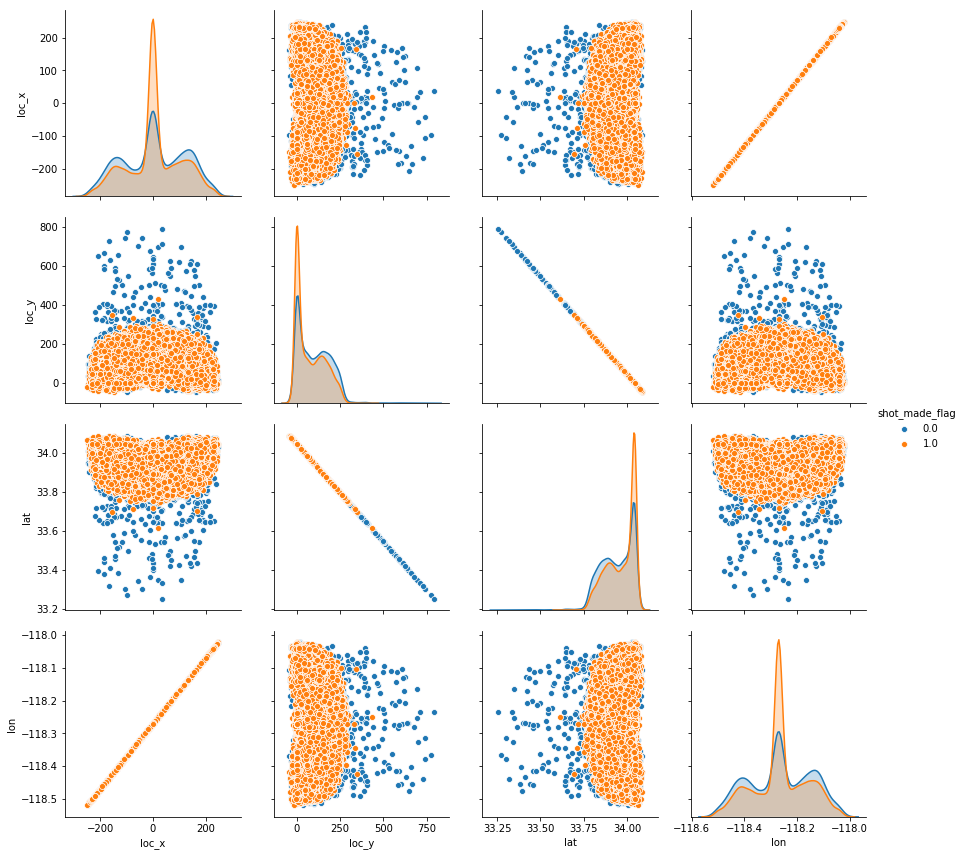

In [33]:
sns.pairplot(data, vars=['loc_x', 'loc_y', 'lat', 'lon'], hue='shot_made_flag', size=3)
plt.show()

видим, что loc_x повторяет lon, а loc_y повторяет lat, только в разных масштабах, возможно lat и lon являются глобальными координатами броска, а loc_x(y) относительно какой-о точки (скорее всего корзины).
Посмотрим насколько сильная между ними линейная связь

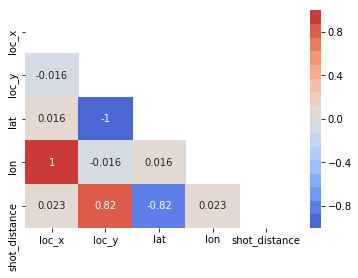

In [34]:
mask = np.triu(np.ones((5, 5)), k=0)
sns.heatmap(data[['loc_x', 'loc_y', 'lat', 'lon', 'shot_distance']].corr(), mask=mask, annot=True, cmap=sns.color_palette('coolwarm', 16))

между loc_x и lon коэффициент корреляции равен 1, а между loc_y и lat -1, следовательно следует удалить по одному признаку из пары с высокой корреляцией, чтобы избежать мультиколлинеарности (уберем lon и lat)

In [35]:
data_cl=data.copy()
data_cl.drop('lat', axis=1, inplace=True)
data_cl.drop('lon', axis=1, inplace=True)

сгруппируем loc_x и loc_y в 25 интервалов, чтобы впоследствии преобразовать их в dummie переменные

In [36]:
data_cl['loc_x_bins'] = pd.cut(data_cl['loc_x'], 25)
data_cl['loc_y_bins'] = pd.cut(data_cl['loc_y'], 25)

также найдем и удалим выбросы дистанций броска - для этого выведем все наблюдения выше 1,5 интерквартильного расстояния от 75го процентиля

объяснение графика "boxplot"


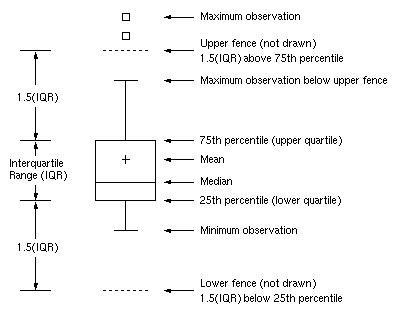

In [37]:
from IPython.display import Image
print('объяснение графика "boxplot"')
Image("boxplot schematic.png")

In [38]:
def outliers(series, whis=1.5):
    q75, q25 = np.percentile(series, [75 ,25])
    iqr = q75 - q25
    return ((series - series.median()).abs() > (whis * iqr))
shots=outliers(data_cl.shot_distance)
shots[shots!=False].index

Int64Index([  177,   313,   322,   397,   585,  1073,  1218,  1605,  1993,
             2523,  2696,  3211,  3506,  3553,  3715,  3839,  4077,  4209,
             4378,  4758,  4864,  5250,  5293,  5355,  5450,  5682,  5854,
             6016,  6050,  6169,  6352,  6418,  6559,  6628,  6650,  7341,
             7526,  8413,  8442,  9269,  9437,  9968,  9999, 10422, 11318,
            11459, 11795, 11919, 12181, 12253, 12647, 12691, 13026, 14801,
            15207, 15430, 15854, 15900, 16589, 16992, 17113, 17569, 17880,
            18151, 18835, 20450, 20498, 20586, 20923, 21355, 21800, 22624,
            23408, 23926, 24135, 24211, 24216, 24228, 24330, 25222, 25439,
            25442, 26162, 26204, 26961, 27024, 27311, 27507, 27656, 27784,
            27991, 28513, 28742, 29122, 29137, 30047, 30149, 30574, 30612,
            30689],
           dtype='int64')

удалим наблюдения с полученными индексами и проверим

In [39]:
data_cl.drop(index=shots[shots!=False].index, inplace=True)
shots=outliers(data_cl.shot_distance)
print('количество выбросов по полю "shot_distance": {}'.format(len(shots[shots!=False].index)))

количество выбросов по полю "shot_distance": 0


# ПЕРЕХОДИМ К ПОСТРОЕНИЮ МОДЕЛИ

1. преобразуем категориальыне переменные - расположим по столбцам, где пересечение с переменной будет давать 1, остальные 0
2. приведем к одному масштабу
3. выделим тренировочную и тестовую выборки
4. построим Linear Regression
5. построим Ridge Regression
6. построим Lasso Regression
7. используем метод главных компонент - PCA
8. сравним результаты
9. сделаем ансамбль

преобразуем категориальные переменные

In [40]:
df=data_cl.copy()

# добавим названия дня недели, далее будем использовать вместо номера
df['weekday_name']=pd.DatetimeIndex(df.game_date).weekday_name

# иключим ненужные атрибуты
useless_cols=['game_id','matchup','shot_id','weekday','team_name', 'team_id', 'game_date','loc_x','loc_y',\
              'combined_shot_type']
df.drop(columns=useless_cols, inplace=True)

# сделаем преобразование категориальных переменных
df_prepared=pd.get_dummies(df)

разделим на тренировочную и тестовую выборки

In [41]:
train=df_prepared[df_prepared.shot_made_flag.isna()==False]
test=df_prepared[df_prepared.shot_made_flag.isna()==True]

train_y=train.shot_made_flag
train_y=pd.DataFrame(train_y).reset_index().drop(columns={'index'})
train_x=train.drop(columns={'shot_made_flag'})

test_y=test.shot_made_flag.reset_index().drop(columns={'index'})
test_x=test.drop(columns={'shot_made_flag'})

приведем к одному масштабу

In [42]:
from sklearn.preprocessing import StandardScaler
train_x_sc=pd.DataFrame(StandardScaler().fit_transform(train_x))
test_x_sc=pd.DataFrame(StandardScaler().fit_transform(test_x))

In [43]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 7, 4

#  посмотрим на величину ошибки в LinearRegression

напишем функцию, в которую по очереди будет передаваться часть датафрейма с разным количеством фич, а на выходе получить оценки коэффициентов линейной регрессии, ошибки и метрика $R^2$ 

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, accuracy_score

def linear_regression(data_x, data_y):
        
# fit
    linreg = LinearRegression(normalize=True)
    linreg.fit(data_x, data_y)
    y_pred = linreg.predict(data_x)
    
# рассчитаем метрики и коэффициенты
    rss = sum((y_pred - np.array(data_y)) ** 2)
    acc=accuracy_score(np.array(train_y), np.round(y_pred))
    ret=[acc]
    R2=r2_score(data_y, y_pred)
    ret.append(R2)
    rse=np.sqrt(rss / (data_x.shape[0] - data_x.shape[1] - 1))
    ret.append(rss[0])
    ret.append(rse[0])
    ret.append(linreg.intercept_[0])
    for i in linreg.coef_[0]:
        ret.append(i)
    return ret

построим модель линейной регрессии и посмотрим на коэффициенты

In [45]:
col = ['accuracy', 'R^2', 'rss', 'rse', 'intercept'] + ['coef_x_%d' % i for i in range(1, len(train_x_sc.columns)+1)]
ind = ['model_pow_%d' % i for i in range(1, len(train_x_sc.columns)+1)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

for i in range(1, len(train_x_sc.columns)+1):
    coef_matrix_simple.iloc[i-1, 0:i+5] = linear_regression(
            train_x_sc[train_x_sc.columns[:i]],
            train_y
    )

pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,accuracy,R^2,rss,rse,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,...,coef_x_187,coef_x_188,coef_x_189,coef_x_190,coef_x_191,coef_x_192,coef_x_193,coef_x_194,coef_x_195,coef_x_196
model_pow_1,0.55,0.0014,6.3e+03,0.5,0.45,-0.019,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,0.55,0.0016,6.3e+03,0.5,0.45,-0.016,0.0075,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,0.55,0.0016,6.3e+03,0.5,0.45,-0.0031,0.011,-0.013,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,0.55,0.0016,6.3e+03,0.5,0.45,-0.0032,0.011,-0.013,-0.00058,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,0.55,0.0023,6.3e+03,0.5,0.45,0.0045,0.012,-0.02,-0.00044,0.013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,0.6,0.038,6.1e+03,0.49,0.45,0.012,0.0099,-0.023,-0.0014,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,0.6,0.038,6.1e+03,0.49,0.45,0.011,0.0095,-0.021,-0.0013,0.0099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,0.6,0.038,6.1e+03,0.49,0.45,0.013,0.01,-0.023,-0.0015,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,0.6,0.04,6.1e+03,0.49,0.45,0.013,0.01,-0.023,-0.0014,0.0099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,0.6,0.04,6.1e+03,0.49,0.45,0.013,0.01,-0.024,-0.0014,0.0099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


довольно сложно по таблице оценить количество фичей, при которых величина ошибки заметно изменяется, попробуем взглянуть на график

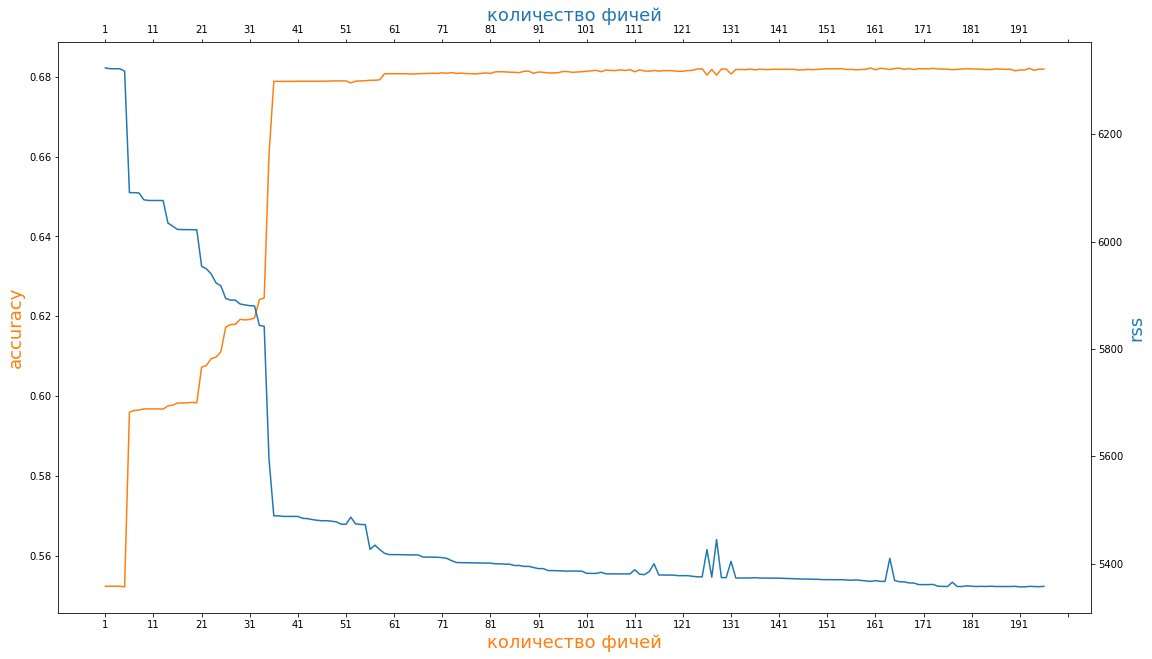

In [46]:
fig=plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.set_xlabel('количество фичей', color="C1", fontsize=18) 
ax.set_ylabel('accuracy', color="C1", fontsize=18)       
ax.xaxis.set_label_position('bottom') 
ax.yaxis.set_label_position('left') 
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

ax.plot([i[10:] for i in coef_matrix_simple.index], coef_matrix_simple.accuracy, color="C1")

ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('количество фичей', color="C0", fontsize=18) 
ax2.set_ylabel('rss', color="C0", fontsize=18)       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))


ax2.plot([i[10:] for i in coef_matrix_simple.index], coef_matrix_simple.rss, color="C0")

примерно на 35й фиче сумма квадратов остатков резко уменьшается, качество модели при этом резко возрастает, а далее держится примерно на одном уровне (интересно, что $R^2$ довольно очень низкий и при 35ти фичах составляет 0,12, надо будет позже в этом разобраться), к тому же очень много коэффициентов близки к нулю

# посмотрим оценки коэффициентов в Ridge регрессии

In [64]:
# результат тот же, проверим регрессию Ridge на тех же данных
from sklearn.linear_model import Ridge

def ridge_regression(data_x, data_y, alpha):
    # Fit
    ridgereg = Ridge(alpha=alpha, normalize=True)
    ridgereg.fit(data_x, data_y)
    y_pred = ridgereg.predict(data_x)
    
    # format
    rss = sum((y_pred-np.array(data_y)) ** 2)
    acc=accuracy_score(np.array(train_y), np.round(y_pred))
    ret=[acc]
#     R2=r2_score(y_pred, np.array(data_y))
    R2=r2_score(data_y, y_pred)
    ret.append(R2)
    rse=np.sqrt(rss / (data_x.shape[0] - data_x.shape[1] - 1))
    ret.append(rss[0])
    ret.append(rse[0])
    ret.extend(ridgereg.intercept_)
    for i in range(len(ridgereg.coef_)):
        ret.extend(ridgereg.coef_[i])
    return ret

In [66]:
# вектор значений коэффициента alpha
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]

# создадим "обложку" для значений модели
col = ['accuracy', 'R^2', 'rss', 'rse', 'intercept'] + ['coef_x_%d' % i for i in range(1, len(train_x_sc.columns)+1)]
ind = ['alpha_%.2g' % alpha_ridge[i] for i in range(0, 10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

for i in range(10):
    coef_matrix_ridge.iloc[i, ] = ridge_regression(train_x_sc, train_y, alpha_ridge[i])
coef_matrix_ridge

,accuracy,R^2,rss,rse,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,...,coef_x_187,coef_x_188,coef_x_189,coef_x_190,coef_x_191,coef_x_192,coef_x_193,coef_x_194,coef_x_195,coef_x_196
alpha_1e-15,0.68,0.15,5.4e+03,0.46,0.45,0.026,0.016,-0.039,-0.0018,0.012,...,0,0,0,-0.0022,-0.0035,0.00046,0.0012,-0.0015,0.0015,0.0028
alpha_1e-10,0.68,0.15,5.4e+03,0.46,0.45,0.026,0.016,-0.039,-0.0018,0.012,...,0,0,0,-0.0022,-0.0035,0.00046,0.0012,-0.0015,0.0015,0.0028
alpha_1e-08,0.68,0.15,5.4e+03,0.46,0.45,0.026,0.016,-0.039,-0.0018,0.012,...,0,0,0,-0.0022,-0.0035,0.00046,0.0012,-0.0015,0.0015,0.0028
alpha_0.0001,0.68,0.15,5.4e+03,0.46,0.45,0.026,0.016,-0.038,-0.0018,0.012,...,0,0,0,-0.0022,-0.0035,0.00046,0.0012,-0.0015,0.0015,0.0028
alpha_0.001,0.68,0.15,5.4e+03,0.46,0.45,0.024,0.016,-0.036,-0.0018,0.012,...,0,0,0,-0.0022,-0.0035,0.00046,0.0012,-0.0015,0.0015,0.0028
alpha_0.01,0.68,0.15,5.4e+03,0.46,0.45,0.011,0.013,-0.025,-0.0019,0.012,...,0,0,0,-0.0021,-0.0035,0.00046,0.0013,-0.0015,0.0015,0.0027
alpha_1,0.68,0.13,5.5e+03,0.47,0.45,-0.0047,0.0043,-0.0044,-0.00051,0.0056,...,0,0,0,-0.00094,-0.0019,0.0003,0.00031,-0.00047,0.0011,0.0011
alpha_5,0.63,0.078,5.8e+03,0.48,0.45,-0.0022,0.0016,-0.002,-0.00013,0.0019,...,0,0,0,-0.00022,-0.00067,2.4e-07,7.4e-06,-7.2e-05,0.0004,0.00035
alpha_10,0.62,0.056,6e+03,0.49,0.45,-0.0013,0.00094,-0.0012,-6.8e-05,0.0011,...,0,0,0,-0.0001,-0.00038,-3.9e-05,-6e-06,-2.8e-05,0.00023,0.0002
alpha_20,0.63,0.037,6.1e+03,0.49,0.45,-0.00077,0.00052,-0.00069,-3.2e-05,0.00058,...,0,0,0,-4.7e-05,-0.00021,-4.1e-05,-4.9e-06,-1.2e-05,0.00013,0.00011


видим, что при $alpha=0.01$ ошибки становятся минимальными(смотрим снизу-вверх), коэффициенты не начинают особо расти, точность модели достаточно высокая, хоть и объясняется всего 0,15 дисперсии всех значений

# построим модель Lasso регрессии

In [67]:
from sklearn.linear_model import Lasso

def lasso_regression(data_x, data_y, alpha):
    # fit
    lassoreg = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
    lassoreg.fit(data_x, data_y)
    y_pred = lassoreg.predict(data_x)
    
# рассчитаем метрики и коэффициенты
    rss=0
# считаем итерационно, иначе умирает ПК
    for i in range(0, len(y_pred)):
        rss  = rss+ (y_pred[i] - np.array(data_y)[i]) ** 2
    
    acc=accuracy_score(np.array(train_y), np.round(y_pred))
    ret=[acc]
    R2=r2_score(data_y, y_pred)
    ret.append(R2)
    rse=np.sqrt(rss / (data_x.shape[0] - data_x.shape[1] - 1))
    ret.append(rss[0])
    ret.append(rse[0])
    ret.append(lassoreg.intercept_[0])
    for i in range(len(lassoreg.coef_)):
        ret.append(lassoreg.coef_[i])    
    return ret

In [57]:
# вектор значений коэффициента alpha
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

# создадим "обложку" для значений модели
col = ['accuracy', 'R^2', 'rss', 'rse', 'intercept'] + ['coef_x_%d' % i for i in range(1, len(train_x_sc.columns)+1)]
ind = ['alpha_%.2g' % alpha_lasso[i] for i in range(0, 10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

# переберем все коэффициенты в векторе и посмотрим как изменятся значения коэффициентов и метрики модели
for i in range(10):
    coef_matrix_lasso.iloc[i,:] = lasso_regression(train_x_sc, train_y, alpha_lasso[i])

D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [58]:
coef_matrix_lasso

,accuracy,R^2,rss,rse,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,...,coef_x_187,coef_x_188,coef_x_189,coef_x_190,coef_x_191,coef_x_192,coef_x_193,coef_x_194,coef_x_195,coef_x_196
alpha_1e-15,0.68,0.15,5.4e+03,0.46,0.45,0.026,0.016,-0.039,-0.0018,0.012,...,0,0,0,-0.0034,-0.0043,-0.00029,-7.5e-05,-0.0024,0.00032,0.0017
alpha_1e-10,0.68,0.15,5.4e+03,0.46,0.45,0.026,0.016,-0.039,-0.0018,0.012,...,0,0,0,-0.0033,-0.0043,-0.00022,4.7e-05,-0.0023,0.00043,0.0018
alpha_1e-08,0.68,0.15,5.4e+03,0.46,0.45,0.026,0.016,-0.039,-0.0018,0.012,...,0,0,0,-0.003,-0.004,-0,0.00042,-0.0021,0.00077,0.0021
alpha_1e-05,0.68,0.15,5.4e+03,0.46,0.45,-0,0.0088,-0.012,-0,0.01,...,0,0,0,-0.0012,-0.0024,0,0,-0.00037,0,0.00076
alpha_0.0001,0.68,0.13,5.5e+03,0.47,0.45,-0.00052,0,-0,0,0,...,0,0,0,-0,-0,0,0,-0,0,0
alpha_0.001,0.55,0,6.3e+03,0.5,0.45,-0,0,-0,-0,0,...,0,0,0,-0,-0,-0,-0,-0,0,0
alpha_0.01,0.55,0,6.3e+03,0.5,0.45,-0,0,-0,-0,0,...,0,0,0,-0,-0,-0,-0,-0,0,0
alpha_1,0.55,0,6.3e+03,0.5,0.45,-0,0,-0,-0,0,...,0,0,0,-0,-0,-0,-0,-0,0,0
alpha_5,0.55,0,6.3e+03,0.5,0.45,-0,0,-0,-0,0,...,0,0,0,-0,-0,-0,-0,-0,0,0
alpha_10,0.55,0,6.3e+03,0.5,0.45,-0,0,-0,-0,0,...,0,0,0,-0,-0,-0,-0,-0,0,0


выберем модель с alpha=1e-05, так как ошибки становятся минимальными(если смотреть снизу-вверх), коэффициенты не начинают особо расти, точность модели достаточно высокая, хоть и объясняется всего 0,15 дисперсии значений (думаю все же это из-за того, что задачу классификации с дискретной целевой переменной решаем регрессионной моделью)

# сравним результаты моделей

In [78]:
linreg=coef_matrix_simple[coef_matrix_simple.index=='model_pow_35'].rename(index={'model_pow_35':'linReg'})
ridgereg=coef_matrix_ridge[coef_matrix_ridge.index=='alpha_0.01'].rename(index={'alpha_0.01':'RidgeReg'})
lassoreg=coef_matrix_lasso[coef_matrix_lasso.index=='alpha_1e-05'].rename(index={'alpha_1e-05':'LassoReg'})
models=pd.concat((linreg, ridgereg, lassoreg))
models.transpose()

,linReg,RidgeReg,LassoReg
accuracy,0.66,0.68,0.68
R^2,0.12,0.15,0.15
rss,5.6e+03,5.4e+03,5.4e+03
rse,0.47,0.46,0.46
intercept,0.45,0.45,0.45
coef_x_1,0.012,0.011,-0
coef_x_2,0.015,0.013,0.0088
coef_x_3,-0.027,-0.025,-0.012
coef_x_4,-0.00029,-0.0019,-0
coef_x_5,0.013,0.012,0.01


модели примено одного качества, заметно как ridge уменьшает коэффициенты по сравнению с линейной регрессией, а lasso их зануляет

можно использовать lasso как инструмент уменьшения размерности

# попробуем предсказать попадание Kobe Brayanta в корзину по подготовленным данным

сначала выберем оптимальные параметры для модели случайного леса

Text(0.5,0,'number of trees')

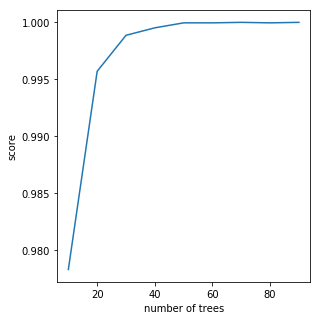

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, log_loss

import warnings
warnings.filterwarnings('ignore')

trees=[]
max_tree=0
f1_score_list=[]

# обучим модель c помощью случайного леса
for tree in range(0,100,10):
    if tree>0:
        rf = RandomForestClassifier(n_estimators=tree)
        rf.fit(train_x_sc, train_y)

        y_train_predict = rf.predict_proba(train_x_sc)[:, 1]
        y_test_predict = rf.predict_proba(test_x_sc)[:, 1]

        score=f1_score(train_y, np.round(y_train_predict))
        f1_score_list.append(score)
        trees.append(tree)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(trees, f1_score_list)
plt.ylabel('score')
plt.xlabel('number of trees')

видим, что качество близкое к 1 достигается уже на 50 деревьях, рассчитаем также глубину

Text(0.5,0,'max depth')

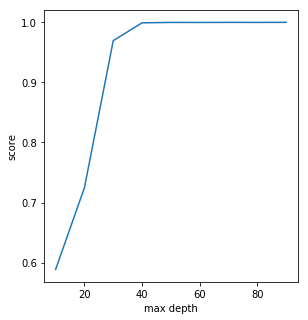

In [130]:
trees=[]
f1_score_list=[]

# обучим модель c помощью случайного леса
for depth in range(0,100,10):
    if depth>0:
        rf = RandomForestClassifier(n_estimators=50, max_depth=depth)
        rf.fit(train_x_sc, train_y)

        y_train_predict = rf.predict_proba(train_x_sc)[:, 1]
        y_test_predict = rf.predict_proba(test_x_sc)[:, 1]

        score=f1_score(train_y, np.round(y_train_predict))
        f1_score_list.append(score)
        trees.append(depth)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(trees, f1_score_list)
plt.ylabel('score')
plt.xlabel('max depth')

мы видим, что при глубине 40 уже достигаем максимальное качество

построим модель на полученных параметрах

In [137]:
rf = RandomForestClassifier(n_estimators=50, max_depth=40)
rf.fit(train_x_sc, train_y)
y_train_predict = rf.predict_proba(train_x_sc)[:, 1]
y_test_predict = rf.predict_proba(test_x_sc)[:, 1]

построим матрицу ошибок и посмотрим на соответствие предсказаний фактическим значениям

In [138]:
from sklearn.metrics import confusion_matrix
conf_matr=pd.DataFrame(confusion_matrix(np.array(train_y), np.round(y_train_predict)))
conf_matr.rename(columns={0:'pred_1',1:'pred_0'}, index={0:'fact_1',1:'fact_0'})

,pred_1,pred_0
fact_1,14140,5
fact_0,31,11433


рассчитаем метрики

In [136]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('precision(точность): {}'.format(precision_score(np.array(train_y), np.round(y_train_predict))))
print('recall(полнота): {}'.format(recall_score(np.array(train_y), np.round(y_train_predict))))
print('accuracy: {}'.format(accuracy_score(np.array(train_y), np.round(y_train_predict))))
print('f1 score: {}'.format(f1_score(train_y, np.round(y_train_predict))))

precision(точность): 0.9998254951574906
recall(полнота): 0.9995638520586183
accuracy: 0.9997266585965872
f1 score: 0.9996946564885496


# модель показала отличный результат на тренировочных данных, жаль нет данных для проверки на тестовых